# Multi-Label Wine Quality Classification


---







In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Context & Workflow in Mind
The dataset is pulled through Kaggle API. The dataset is related to red variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009].

### **Tools & Models**


**The plan** is to use the dataset to train some multi-label classification models using different ML models and compare their performance + analyze why they differentiate: 


*   Logistic regression
*   K-NN
*   SVM



### **Workflow**



*   Import libraries & data
*   Exploratory analysis & Data visualization
*   Data preprocessing
*   Rapid prototyping (train a logistic regression classifer with one vs. all method)
*   Feature engineering
*   Interating for better accuracy

## Import Libararies

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Use the right version of TensorFlow
The following hidden code cell ensures that the Colab will run on TensorFlow 2X.

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

## Downloading dataset (Kaggle API)

Not sure comparing with downloading dataset from Kaggle which method is better. My understanding is using API might just demostrate a bit more knowledge of API and also can indicate the data source. The down side could be I'm exposing my user name and token?

In [ ]:
#@title Setting up Kaggle API
#!pip install kaggle
!rm -r .kaggle
!mkdir .kaggle

import json
token = {"username":"MY USER NAME","key":"<KEY>"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [ ]:
# Downloading dataset from Kaggle
#@title Viewing datasets from Kaggle
!kaggle datasets list -s Red

ref                                              title                                         size  lastUpdated          downloadCount  
-----------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
uciml/red-wine-quality-cortez-et-al-2009         Red Wine Quality                              26KB  2017-11-27 23:41:08          51748  
piyushgoyal443/red-wine-dataset                  Red Wine Dataset                              29KB  2017-03-05 03:38:35           6036  
unanimad/dataisbeautiful                         Reddit - Data is Beautiful                    12MB  2020-06-19 11:33:00           3383  
danofer/sarcasm                                  Sarcasm on Reddit                            216MB  2018-05-27 08:19:04           4842  
sayangoswami/reddit-memes-dataset                Reddit Memes Dataset                         634MB  2018-04-16 19:13:18           2230  
reddit/reddit-comments-may-2015   

In [ ]:
# Copy the API key from Kaggle and set the path -p
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009 -p /content/

# Unzip the datasets just downloaded
!unzip \*.zip
# Remove the extra .zip file
!rm /content/*.zip

  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 10.2MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


## Importing Dataset

In [5]:
wine_df = pd.read_csv("./drive/My Drive/Multi-label Wine Quality Classification/winequality-red.csv")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
wine_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [ ]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Feature Visualization

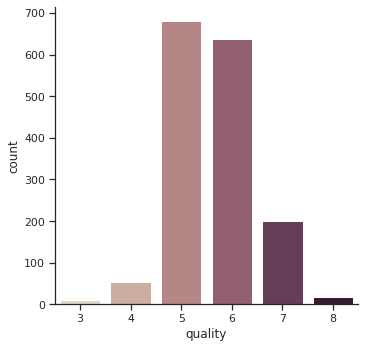

In [ ]:
# Visualize the label distribustion first
sns.set(style="ticks", color_codes=True)

sns.catplot(x="quality", kind="count", palette="ch:.25", data=wine_df);

Note that the classes are pretty unenvenly distributed. There are much more normal wines than excellent or poor ones (Need to research more on how to deal with situation). In general seems we got 6 categaories in here from grading 3 - 8.

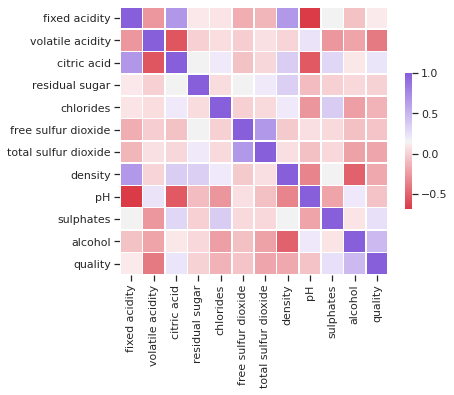

In [ ]:
corr = wine_df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(10, 275, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)

Seems PH and fixed acidity, citric acid and PH/volatile acidity have high negtive correlation. Later we can consider to combine these features or pick only one. However, for now let's get something quick and dirty working first.

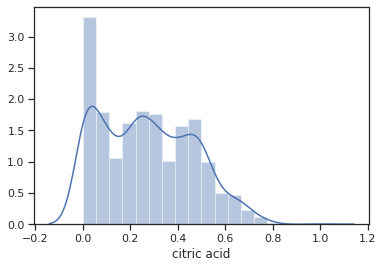

In [ ]:
# Visualize the distribution of citric acid since previously apply .describe() on wine_df citric acid has a minimum of 0
citric_acid = pd.Series(wine_df.loc[:,'citric acid'])
sns.distplot(citric_acid)

Not sure if citric acid = 0 is valid or not. But from the histogram chart above we observe there're lots of data that has = 0 citric acid so let's assume it's valid in here since the distribution curve is smooth.

## Data Preprocessing (Feature Scaling)

### Encoding the 'quality' col


In [ ]:
wine_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [ ]:
# Making binary classificaion for the response variable.
# Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6, 8)
group_names = ['bad', 'good']
wine_df['quality'] = pd.cut(wine_df['quality'], bins = bins, labels = group_names)

In [ ]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


In [ ]:
#Now lets assign a labels to our quality variable
from sklearn.preprocessing import LabelEncoder
label_quality = LabelEncoder()

#Bad becomes 0 and good becomes 1 
wine_df['quality'] = label_quality.fit_transform(wine_df['quality'])
wine_df['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [ ]:
# .values Return a Numpy representation of the DataFrame
X = wine_df.iloc[:, :-1].values
y = wine_df.iloc[:, -1].values

### Splitting into Training/Test Sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train)

[[ 7.     0.65   0.02  ...  3.47   0.67   9.5  ]
 [10.2    0.42   0.57  ...  3.04   0.63   9.6  ]
 [ 5.2    0.34   0.    ...  3.68   0.79  14.   ]
 ...
 [ 6.6    0.725  0.09  ...  3.35   0.49  10.8  ]
 [ 7.2    0.63   0.    ...  3.37   0.58   9.   ]
 [ 9.1    0.4    0.5   ...  3.21   0.69  12.5  ]]


### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_tranform call .fit() to compute the mean and std deviation for later use 
X_train = scaler.fit_transform(X_train)
# No need to call fit_transform again since the params have been computed in the previous line
X_test = scaler.transform(X_test)

In [ ]:
print(X_train)

[[-0.73307913  0.6648928  -1.25704443 ...  0.98846046  0.0630946
  -0.87223395]
 [ 1.06774091 -0.62346154  1.52314768 ... -1.7535127  -0.17390392
  -0.77978452]
 [-1.74604041 -1.07158479 -1.35814232 ...  2.32756363  0.77409018
   3.28799021]
 ...
 [-0.95818164  1.08500835 -0.90320179 ...  0.22325865 -1.00339876
   0.32960859]
 [-0.62052788  0.55286199 -1.35814232 ...  0.35079228 -0.47015208
  -1.33448108]
 [ 0.44870902 -0.73549236  1.16930505 ... -0.6694768   0.18159387
   1.90124882]]


## Train Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression():
  # No params are passing in here into the LogisticRegression class (i.e. no tuning)
  classifier = LogisticRegression(random_state = 0);
  classifier.fit(X_train, y_train)
  return classifier

In [ ]:
classifier = train_logistic_regression()

## Predicting the Test Set Results

In [ ]:
# Predit the test data
y_pred = classifier.predict(X_test)

# Reshape both y_pred & y_test from col vectors to row vectors
y_pred_reshaped = y_pred.reshape(len(y_pred),1)
y_test_reshaped = y_test.reshape(len(y_test),1)
print('Predicted  Test')

# Print out the first 10 results
print(np.concatenate((y_pred_reshaped[:10], y_test_reshaped[:10]),1))

Predicted  Test
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


## Making the confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_test, y_pred):
  return confusion_matrix(y_test, y_pred)

confusion = make_confusion_matrix(y_test, y_pred)
print(confusion)

#compute recall & precision & f score

[[276  12]
 [ 25   7]]
